# Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This is A/B test is to examine the potential effect of applying a new page design. The chosen metric was the conversion rate. The test has run over a period of time and the details of the transactions were recorded in a csv file> we shall consider three different approached towards reaching a conclusion. namely, a probability approach, A/B testing apporach and finally with a regression approach.

<a id='probability'></a>
#### Part I - Probability



In [1]:
# Importing the necssary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
# Reading the source file
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# how many rows in the original dataframe
df.shape

(294478, 5)

In [4]:
# Number of unique users
unique_users = df.user_id.nunique()
unique_users

290584

In [5]:
# Proportion of users converted
users_converted = df.converted.mean()
users_converted

0.11965919355605512

**The total number of mismatches between group and landing_page has two components**

In [6]:
# The first component is where landing_page is new_page while group is not treatment
a = df.query('(landing_page == "new_page") and (group != "treatment")').user_id.count()


In [7]:
# The second component is where landing_page is old_page while group is not control
b = df.query('(landing_page == "old_page") and (group!= "control")').user_id.count()


In [8]:
total_mismatch = a + b
total_mismatch

3893

f. Do any of the rows have missing values?

In [9]:
# fining missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**There are no missing values**

In [10]:
# There are two components for the mismatched group and landing page
# We shalll create two separate dataframes and then we cancatenate them together
df2_control = df.query('group == "control" & landing_page == "old_page"')
df2_treatment = df.query('group == "treatment" & landing_page == "new_page"')

In [11]:
# the combined dataframe after removing the misaligned records
df2 = pd.concat([df2_control,df2_treatment ])

In [12]:
df2.shape

(290585, 5)

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [14]:
# Number of unique user id in df2
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
# Locating the duplicated user_id
df2.user_id[df2.user_id.duplicated(keep=False)]

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
# Removing the duplicated user_id
df2.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [18]:
# Checking duplicated item has been removed.
df2.duplicated().sum()

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
# Probability of conversion in df2
prob_converted = df2.converted.mean()
prob_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
# Connditional probabiliy of conversion given that user was in contorl group
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
# Connditional probabiliy of conversion given that user was in treatment group
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

## d. What is the probability that an individual received the new page?

In [22]:
df2.query('landing_page == "new_page"').user_id.count()/ df2.shape[0]

0.50006194422266881

### Conclusion (Part I)
* **Given that the probability of being landed to new_page is 50%, we can say there was an equal chance of being landed to either page equally**.
* **Actually, given this small difference in conversion rates between the old and new design, we cannot give any direct suggestion which design is bette. As we don't have statistcal evidence, we should run here an A/B testing to check it further.**

<a id='ab_test'></a>
### Part II - A/B Test


we shall state the hypothesis as follow:

$$H_0: p_{new} - p_{old} \leq 0  $$
$$H_1: p_{new} - p_{old} > 0 $$

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [23]:
# Conversion Rate for new_page
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [24]:
# Conversion Rate for old_page
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
# number of users who got the new_page
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
# number of users who got the old_page
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
# simulate new_page conversion under null for n_new and p_new
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1 - p_new)])
new_page_converted.mean()
    

0.12010873305347189

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
# simulate old_page conversion under null for n_old and p_old
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1 - p_old)])
old_page_converted.mean()

0.11839696022688162

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
# The observed differenc based on the simulated data
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.0017117728265902687

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
""" In order to avoid using for loop - whihc is computational ineffecient - we shall use the Numpy function to simulate the
10,000 samples"""
new_page_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted_simulation - old_page_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

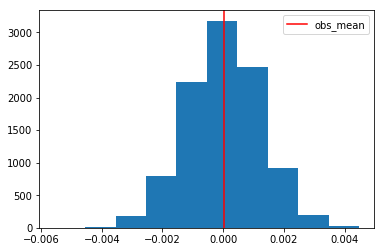

In [31]:
# Creating A histogram for p_diffs
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.axvline(p_diffs.mean(), color='r', label='obs_mean')
plt.legend()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
actual_mean = df2.converted[df2.group == 'treatment'].mean() - df2.converted[df2.group == 'control'].mean()
(actual_mean < p_diffs).mean()

0.90490000000000004

### Conclusion(Part II)

* **What we have caculated in point -j is the p-value for that null hypothesis.**
* **this value can be used - in conjection of type I error - to judge the null hypothesis**
* **Based on the above p-value (whihc is quite large in comparison to type I error - so we can conclude that we don't have any statistical evdidence to reject the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2[df2.group == 'control'].converted.sum()
convert_new = df2[df2.group == 'treatment'].converted.sum()
n_old = df2[df2.group == 'control'].converted.count()
n_new = df2[df2.group == 'treatment'].converted.count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

* **a z-score (also called a standard score) gives you an idea of how far from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is**
 <https://www.statisticshowto.com/probability-and-statistics/z-score/>

* **The resulted p-value is very  similar to the one we got above. Then we fail to reject the Null Hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**This is a caase of logistic regression. as we are prediction a binary value where "1" represents converted and "0" represents  not converted**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# Make a copy of df2
df2_copy = df2.copy()
df2_copy.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [36]:
# add an intercept
df2_copy['intercept'] = 1

# Creating dummy varaiable for both landing_page and group columns
df2_copy[['landing_page_new', 'landing_page_old']] = pd.get_dummies(df2_copy['landing_page'])
df2_copy[['ab_page_control','ab_page_treatment']] = pd.get_dummies(df2_copy['group'])

# Drop landing_page_old and ab_page_control
df2_copy.drop(['landing_page_old','ab_page_control'], axis=1, inplace=True)

In [37]:
df2_copy.head()

,user_id,timestamp,group,landing_page,converted,intercept,landing_page_new,ab_page_treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
model = sm.Logit(df2_copy['converted'], df2_copy[['intercept', 'ab_page_treatment']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
===================================================================
Model:               Logit            No. Iterations:   6.0000     
Dependent Variable:  converted        Pseudo R-squared: 0.000      
Date:                2021-01-12 08:54 AIC:              212780.3502
No. Observations:    290584           BIC:              212801.5095
Df Model:            1                Log-Likelihood:   -1.0639e+05
Df Residuals:        290582           LL-Null:          -1.0639e+05
Converged:           1.0000           Scale:            1.0000     
-------------------------------------------------------------------
                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
intercept         -1.9888   0.0081 -246.6690 0.0000 -2.0046 -1.9730
ab_page_treatment -0.0150   0.0114   -1.3109 0.1899 -0.0374  0.0074
===================================================================

"""

**The Calculated p-value and its interpretion**

* **The calculated p-value by regression model is a two- sided hypothesis which can be stated like that:**
$$H_0: p_{new} - p_{old}  = 0 $$
$$H_1: p_{new} - p_{old} \neq 0 $$
* **In order to get the one-sided p_val is to use the following formula: 1 - p_val/2**
* **The one sided p_val is then equal to 1- (0.19/2) = 0.905 which is almost idential to the value we got in partII**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- **We should be cautious when deciding to add other features. due to multi-colinearity issues. But, in general we can test adding other features and see the effect on the accuracy of the prediction.**
- **Geographical location might be a good fatrure to consider too**
- **The disadvantge might be the complexity of the model, along with the multi-colinearity issues that might rise.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [41]:
df_new.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


In [46]:
#country unique values
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [55]:
# Adding the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new[['ab_page_old', 'ab_page_new']] = pd.get_dummies(df_new['landing_page'])
# let's consider US being our baseline, therefore, we drop US
# let's consider ab_page_old as a baseline, therefore we drop it
df_new.drop(['US'], axis=1, inplace=True)
df_new.drop(['ab_page_old'], axis=1, inplace=True)
df_new.head()

,country,timestamp,group,landing_page,converted,CA,UK,ab_page_new
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0


In [56]:
# Adding the intercept Column
df_new['intercept'] = 1
df_new.head()

,country,timestamp,group,landing_page,converted,CA,UK,ab_page_new,intercept
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [57]:
# Fitting Regression Model
model = sm.Logit(df_new['converted'], df_new[['intercept','CA','UK', 'ab_page_new']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [58]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-12 09:04 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0042    0.0089  -224.5600  0.0000  -2.0217  -1.9867
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
ab_page_new   0.0149    0.0114     1.3069  0.1912  -0.0075   0.0374
==================================================================

"""

In [59]:
# Intercepts for  Canada and UK
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

<a id='conclusions'></a>
## Finishing Up (Final Conclusion)
** we have run 3 different methods to test the significance of the proposed new page design. the three methhods have rendered consistent findings.
to recap: we did not see any statistical evidence to support the alternative hypothesis. and hence, we shall recommend to keep the old page design.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [60]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0